Dataset : https://www.kaggle.com/datasets/aslanahmedov/walmart-sales-forecast

Import Modul

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

Baca Dataset

In [81]:
df = pd.read_csv('/content/train.csv')

In [82]:
df.tail()

,Store,Dept,Date,Weekly_Sales,IsHoliday
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False
421569,45,98,2012-10-26,1076.80,False


Hilangkan kolom Store, Dept, IsHoliday

In [83]:
df.drop(columns=['Store', 'Dept', 'IsHoliday'])

,Date,Weekly_Sales
0,2010-02-05,24924.50
1,2010-02-12,46039.49
2,2010-02-19,41595.55
3,2010-02-26,19403.54
4,2010-03-05,21827.90
...,...,...
421565,2012-09-28,508.37
421566,2012-10-05,628.10
421567,2012-10-12,1061.02
421568,2012-10-19,760.01


Ambil hanya 5000 data

In [84]:
df = df[:5000]

In [85]:
dates = df['Date'].values
sales = df[['Weekly_Sales']].values

Text(0.5, 1.0, 'Sales Average')

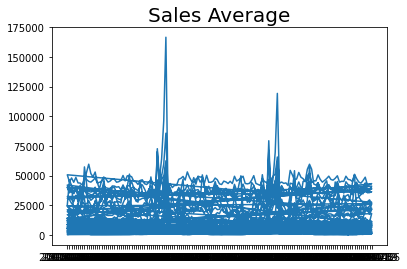

In [86]:
plt.plot(dates, sales)
plt.title('Sales Average',
          fontsize=20)

Gunakan Scaler untuk normalisasi data

In [87]:
scaler = MinMaxScaler()
scaled_sales = scaler.fit_transform(sales)

In [88]:
scaled_sales

array([[0.15023103],
       [0.27679134],
       [0.25015499],
       ...,
       [0.02084545],
       [0.01901169],
       [0.01740479]])

In [89]:
scaled_sales.shape

(5000, 1)

Ubah dimensi array

In [90]:
scaled_sales = np.reshape(scaled_sales, newshape=(-1))

In [91]:
scaled_sales.shape

(5000,)

Text(0.5, 1.0, 'Sales Average')

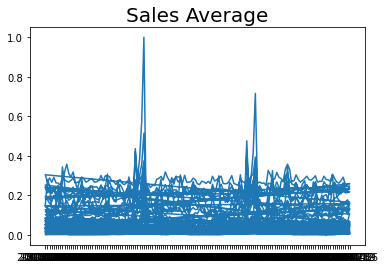

In [92]:
plt.plot(dates, scaled_sales)
plt.title('Sales Average',
          fontsize=20)

Bagi Dataset

In [93]:
sales_train, sales_test, dates_train, dates_test = train_test_split(scaled_sales, dates, test_size=0.2, random_state=1)

Windowed dataset

In [94]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [95]:
train_set = windowed_dataset(sales_train, window_size=30, batch_size=100, shuffle_buffer=1000)

Model

In [97]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(1),
])

Optimizer

In [98]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

Implementasi Callback

In [99]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [100]:
my_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

Train Model

In [101]:
history = model.fit(train_set,epochs=50, callbacks=[my_callback])

Epoch 1/50
40/40 [==============================] - 9s 120ms/step - loss: 0.0073 - mae: 0.0866 - lr: 1.0000e-04
Epoch 2/50
40/40 [==============================] - 5s 120ms/step - loss: 0.0064 - mae: 0.0775 - lr: 1.0000e-04
Epoch 3/50
40/40 [==============================] - 5s 119ms/step - loss: 0.0057 - mae: 0.0709 - lr: 1.0000e-04
Epoch 4/50
40/40 [==============================] - 5s 120ms/step - loss: 0.0052 - mae: 0.0667 - lr: 1.0000e-04
Epoch 5/50
40/40 [==============================] - 5s 120ms/step - loss: 0.0047 - mae: 0.0638 - lr: 1.0000e-04
Epoch 6/50
40/40 [==============================] - 5s 121ms/step - loss: 0.0043 - mae: 0.0623 - lr: 1.0000e-04
Epoch 7/50
40/40 [==============================] - 5s 120ms/step - loss: 0.0041 - mae: 0.0619 - lr: 1.0000e-04
Epoch 8/50
40/40 [==============================] - 5s 122ms/step - loss: 0.0039 - mae: 0.0622 - lr: 1.0000e-04
Epoch 9/50
40/40 [==============================] - 5s 121ms/step - loss: 0.0038 - mae: 0.0624 - lr: 1.0

Plot Loss

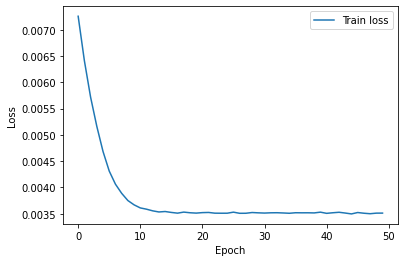

In [102]:
loss = history.history['loss']
plt.plot(loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss'], loc='upper right')
plt.show()

Plot Mae

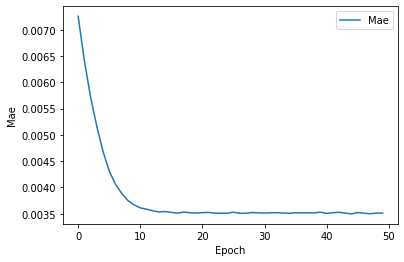

In [103]:
mae = history.history['mae']
plt.plot(loss)
plt.ylabel('Mae')
plt.xlabel('Epoch')
plt.legend(['Mae'], loc='upper right')
plt.show()